https://www.kaggle.com/code/prasadiw/time-series-forecasting-stock-prices/notebook

In [1]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np
import statsmodels
#Importing libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

#Importing library for date manipulation
from datetime import datetime

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

#Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('TSLA.csv')
df = df.drop(columns=['Open','High','Low','Adj Close','Volume'])
df.head()


,Date,Close
0,2016-08-16,44.722000
1,2016-08-17,44.647999
2,2016-08-18,44.702000
3,2016-08-19,45.000000
4,2016-08-22,44.585999


In [3]:
df.rename(columns={'Date':'date','Close':'close'},inplace=True)
df.info

<bound method DataFrame.info of             date       close
0     2016-08-16   44.722000
1     2016-08-17   44.647999
2     2016-08-18   44.702000
3     2016-08-19   45.000000
4     2016-08-22   44.585999
...          ...         ...
1253  2021-08-09  713.760010
1254  2021-08-10  709.989990
1255  2021-08-11  707.820007
1256  2021-08-12  722.250000
1257  2021-08-13  717.169983

[1258 rows x 2 columns]>

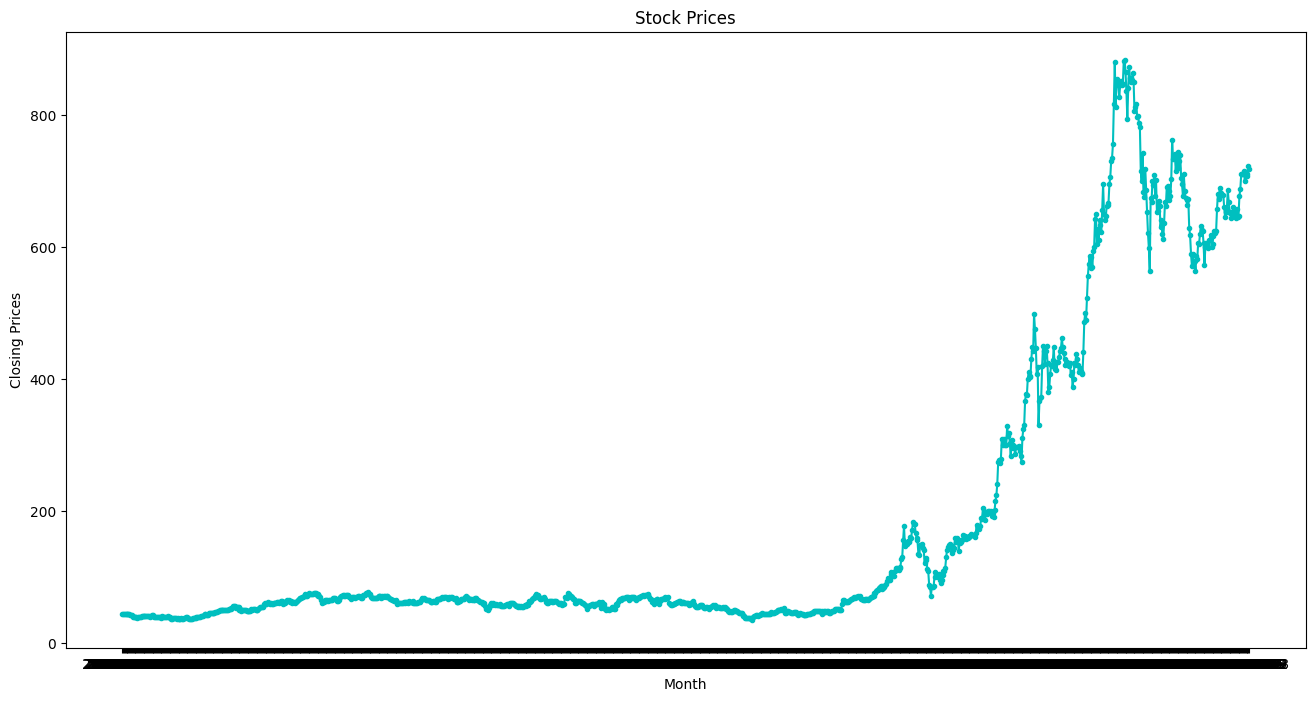

In [4]:
# Setting date as the index
df = df.set_index(['date'])
df.head()

# Visualizing the time series
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('Stock Prices')
plt.plot(df.index, df.close, color = 'c', marker='.')

In [5]:
# Splitting the data into train and test
split_index = int(0.8 * len(df))
df_train = df[:split_index]
df_test = df[split_index:]
print(df_train)
print(df_test)

                 close
date                  
2016-08-16   44.722000
2016-08-17   44.647999
2016-08-18   44.702000
2016-08-19   45.000000
2016-08-22   44.585999
...                ...
2020-08-07  290.541992
2020-08-10  283.713989
2020-08-11  274.877991
2020-08-12  310.951996
2020-08-13  324.200012

[1006 rows x 1 columns]
                 close
date                  
2020-08-14  330.141998
2020-08-17  367.127991
2020-08-18  377.417999
2020-08-19  375.705994
2020-08-20  400.365997
...                ...
2021-08-09  713.760010
2021-08-10  709.989990
2021-08-11  707.820007
2021-08-12  722.250000
2021-08-13  717.169983

[252 rows x 1 columns]


Now let us check the rolling mean and standard deviation of the series to visualize if the series has any trend or seasonality.

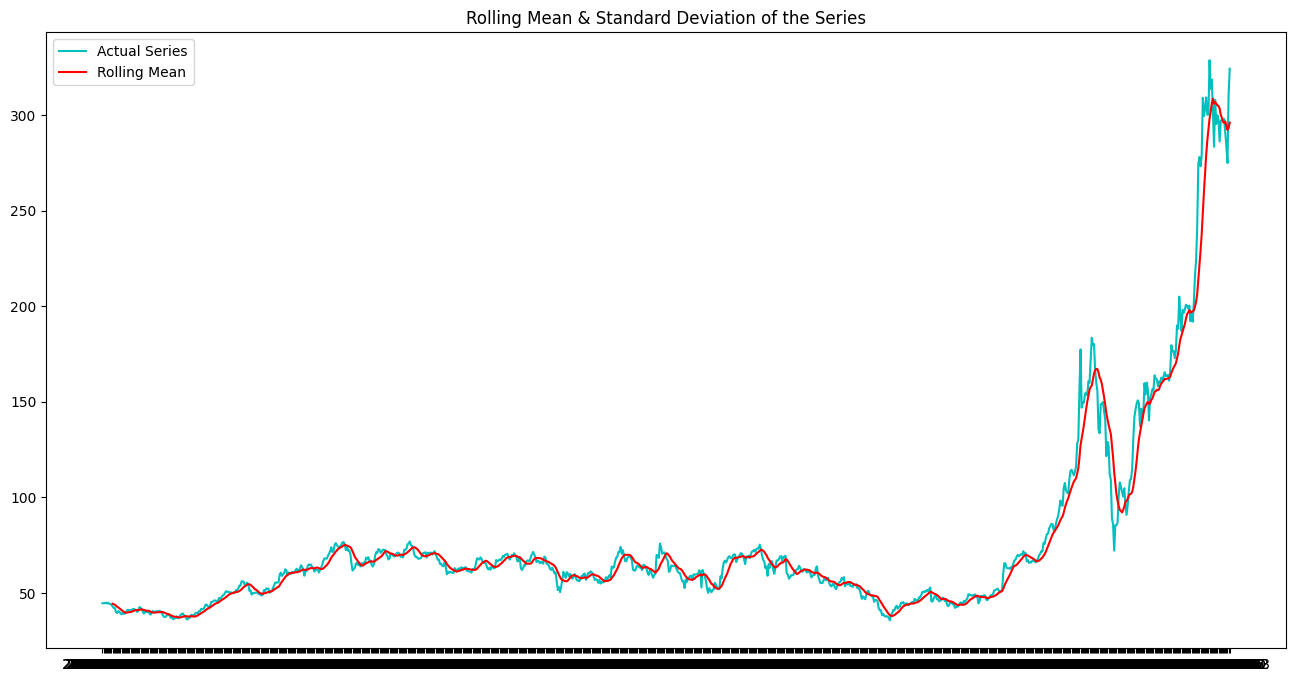

In [6]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=10).mean()
rolstd=df_train.rolling(window=10).std()

#Visualizing the rolling mean and standard deviation
plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 

#rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

In [7]:
# Baseline Models
constant_value = df_train['close'].mean()
constant_forecast = pd.Series([constant_value] * len(df_test), index=df_test.index)

persistence_value = df_train['close'].iloc[-1]
persistence_forecast = pd.Series([persistence_value] * len(df_test), index=df_test.index)

naive_forecast = df_train['close'].shift(1).dropna()

# Ensure the lengths match for calculating MSE
naive_forecast = naive_forecast[-len(df_test):]

In [8]:
# Evaluate Mean Squared Error for each model
mse_constant = mean_squared_error(df_test, constant_forecast)
mse_persistence = mean_squared_error(df_test, persistence_forecast)
mse_naive = mean_squared_error(df_test, naive_forecast)

# Print MSE values
print(f'Constant Forecast Mean Squared Error (MSE): {mse_constant}')
print(f'Persistence Forecast Mean Squared Error (MSE): {mse_persistence}')
print(f'Naive Forecast Mean Squared Error (MSE): {mse_naive}')

Constant Forecast Mean Squared Error (MSE): 306660.23151210527
Persistence Forecast Mean Squared Error (MSE): 102038.40168204268
Naive Forecast Mean Squared Error (MSE): 248297.5953051635


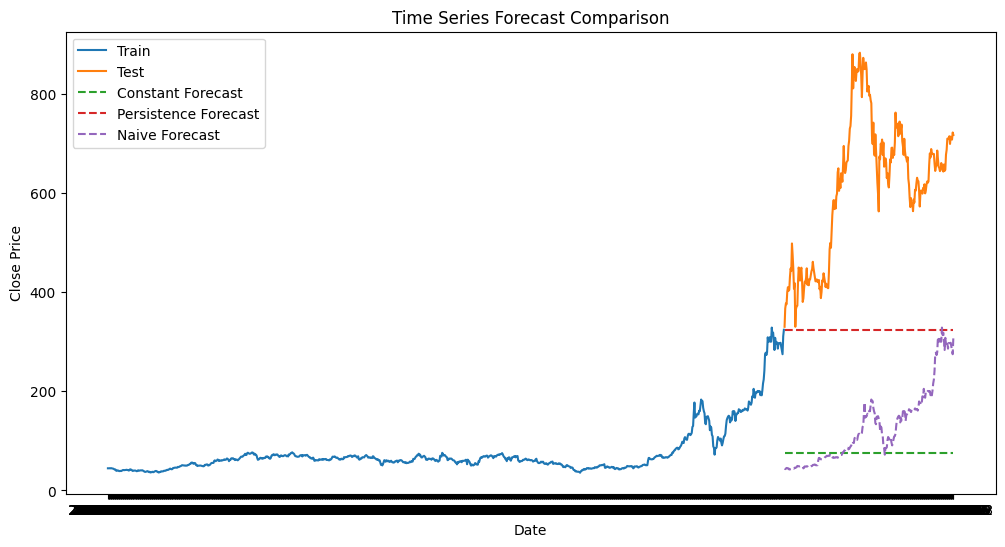

In [9]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train, label='Train')
plt.plot(df_test.index, df_test, label='Test')

# Plot baseline models
plt.plot(df_test.index, constant_forecast, label='Constant Forecast', linestyle='--')
plt.plot(df_test.index, persistence_forecast, label='Persistence Forecast', linestyle='--')
plt.plot(df_test.index, naive_forecast, label='Naive Forecast', linestyle='--')

plt.title('Time Series Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Best SARIMA Order: (1, 1, 1, 0, 1, 1, 12) with AIC=5716.318787646136 based on GRID Search

In [ ]:
# SARIMA Model
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 365)

model = SARIMAX(df_train, order=order, seasonal_order=seasonal_order)
result = model.fit(disp=False)
forecast_steps = len(df_test)
forecast = result.get_forecast(steps=forecast_steps)
sarima_predicted_values = forecast.predicted_mean

#Evaluate MSE
mse_sarima = mean_squared_error(df_test, sarima_predicted_values)
print(f'SARIMA Forecast Mean Squared Error (MSE): {mse_sarima}')

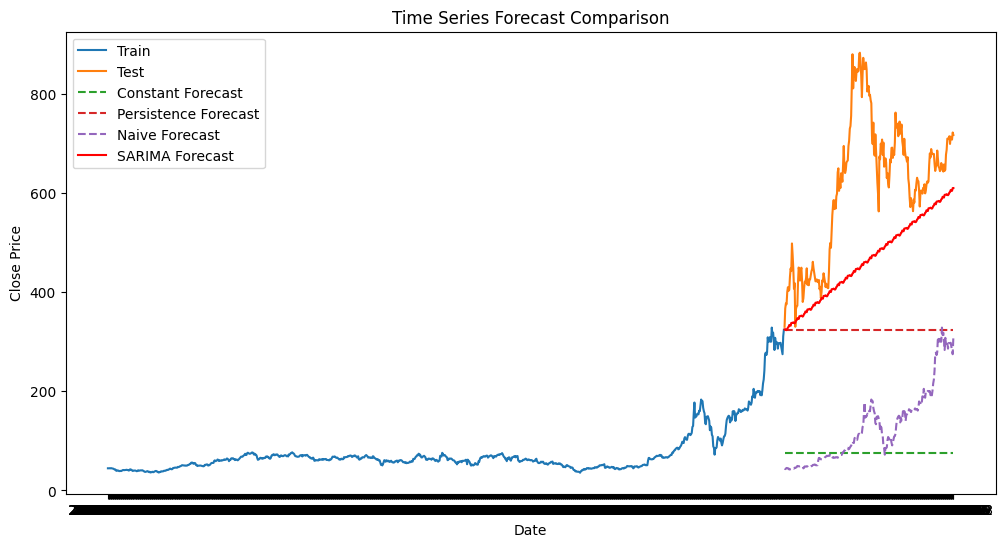

In [23]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train, label='Train')
plt.plot(df_test.index, df_test, label='Test')

# Plot baseline models
plt.plot(df_test.index, constant_forecast, label='Constant Forecast', linestyle='--')
plt.plot(df_test.index, persistence_forecast, label='Persistence Forecast', linestyle='--')
plt.plot(df_test.index, naive_forecast, label='Naive Forecast', linestyle='--')

# Plot SARIMA forecast
plt.plot(df_test.index, sarima_predicted_values, color='red', label='SARIMA Forecast')

plt.title('Time Series Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

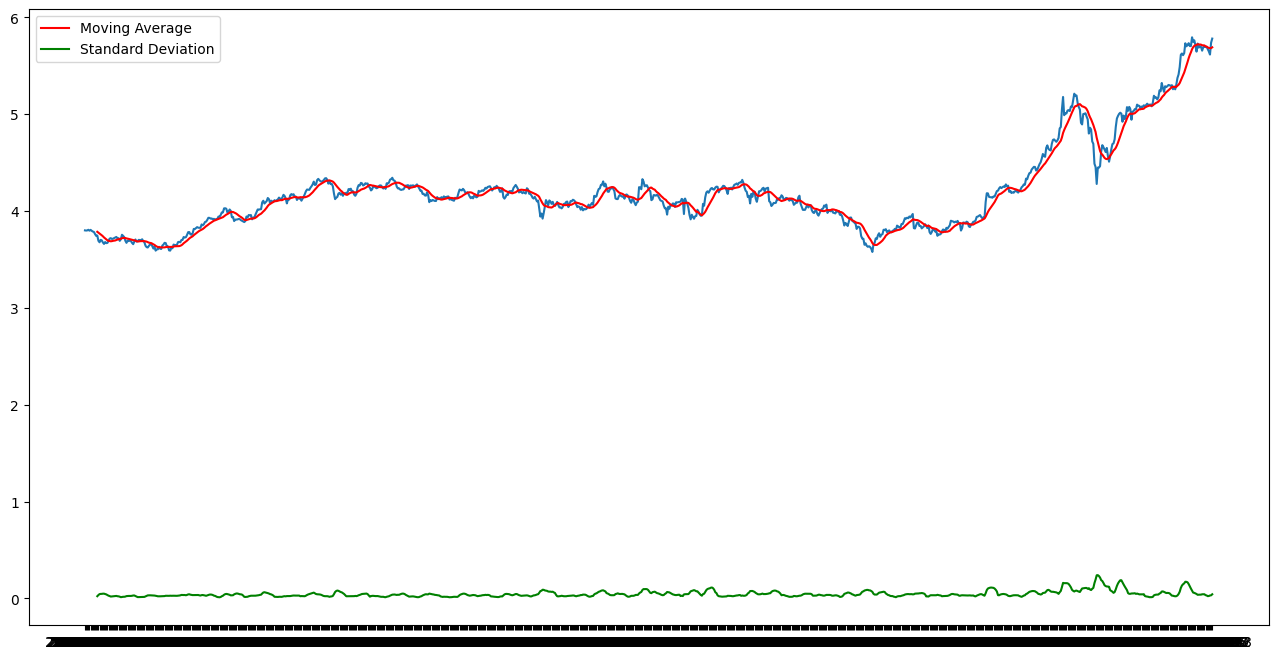

In [24]:
#Apply log transformation to Normalise data
df_log = np.log(df_train)
df_log_test = np.log(df_test)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()

# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

In [25]:
# Baseline Models
constant_value = df_log['close'].mean()
constant_forecast = pd.Series([constant_value] * len(df_log_test), index=df_log_test.index)

persistence_value = df_log['close'].iloc[-1]
persistence_forecast = pd.Series([persistence_value] * len(df_log_test), index=df_log_test.index)

naive_forecast = df_log['close'].shift(1).dropna()

# Ensure the lengths match for calculating MSE
naive_forecast = naive_forecast[-len(df_log_test):]

In [26]:
# Evaluate Mean Squared Error for each model
mse_constant = mean_squared_error(df_log_test, constant_forecast)
mse_persistence = mean_squared_error(df_log_test, persistence_forecast)
mse_naive = mean_squared_error(df_log_test, naive_forecast)

# Print MSE values
print(f'Constant Forecast Mean Squared Error (MSE): {mse_constant}')
print(f'Persistence Forecast Mean Squared Error (MSE): {mse_persistence}')
print(f'Naive Forecast Mean Squared Error (MSE): {mse_naive}')

Constant Forecast Mean Squared Error (MSE): 4.83327019362814
Persistence Forecast Mean Squared Error (MSE): 0.42771596950116175
Naive Forecast Mean Squared Error (MSE): 3.1314529048886506


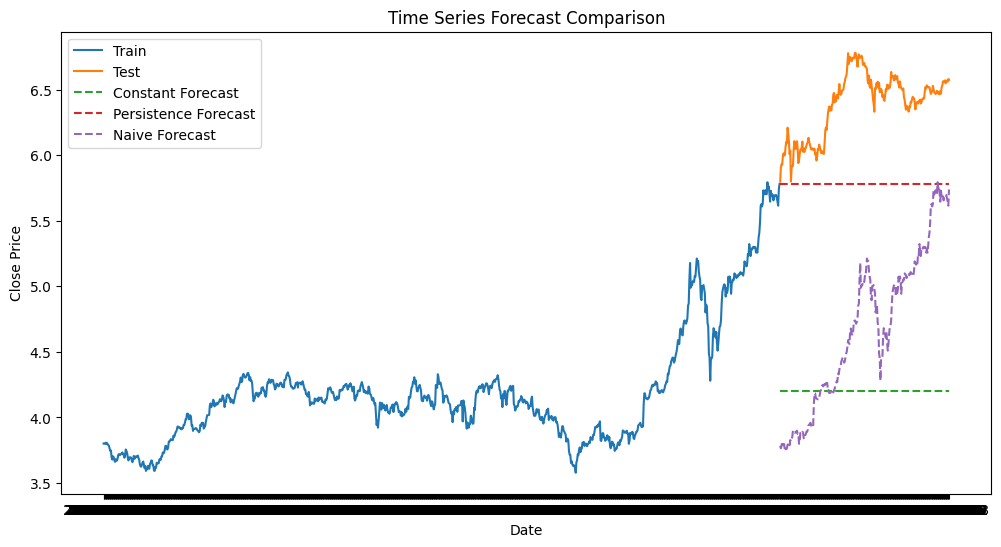

In [27]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_log.index, df_log, label='Train')
plt.plot(df_log_test.index, df_log_test, label='Test')

# Plot baseline models
plt.plot(df_log_test.index, constant_forecast, label='Constant Forecast', linestyle='--')
plt.plot(df_log_test.index, persistence_forecast, label='Persistence Forecast', linestyle='--')
plt.plot(df_log_test.index, naive_forecast, label='Naive Forecast', linestyle='--')

plt.title('Time Series Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [28]:
# SARIMA Model
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

model = SARIMAX(df_log, order=order, seasonal_order=seasonal_order)
result = model.fit(disp=False)
forecast_steps = len(df_log_test)
forecast = result.get_forecast(steps=forecast_steps)
sarima_predicted_values = forecast.predicted_mean

#Evaluate MSE
mse_sarima = mean_squared_error(df_log_test, sarima_predicted_values)
print(f'SARIMA Forecast Mean Squared Error (MSE): {mse_sarima}')

SARIMA Forecast Mean Squared Error (MSE): 0.1237426594753385


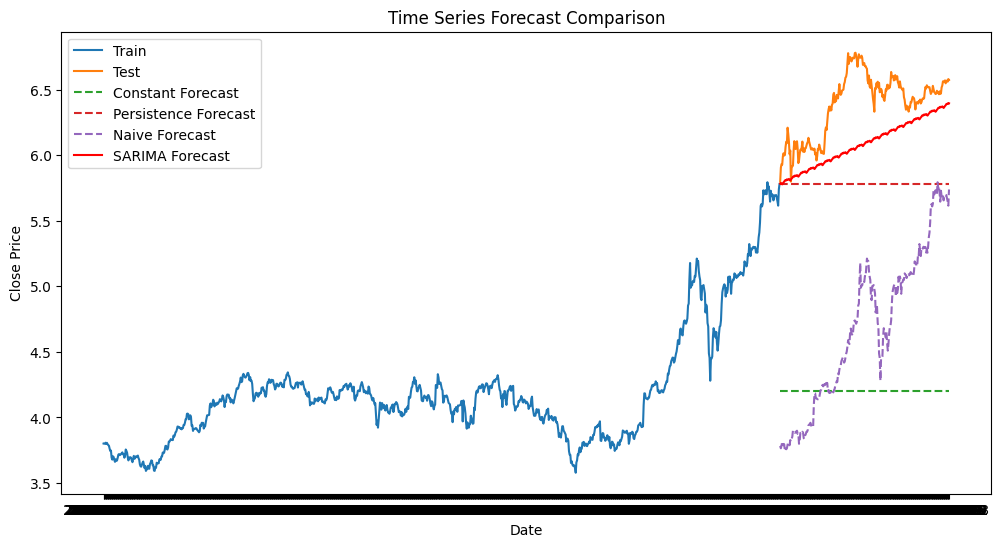

In [29]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_log.index, df_log, label='Train')
plt.plot(df_log_test.index, df_log_test, label='Test')

# Plot baseline models
plt.plot(df_log_test.index, constant_forecast, label='Constant Forecast', linestyle='--')
plt.plot(df_log_test.index, persistence_forecast, label='Persistence Forecast', linestyle='--')
plt.plot(df_log_test.index, naive_forecast, label='Naive Forecast', linestyle='--')

# Plot SARIMA forecast
plt.plot(df_log_test.index, sarima_predicted_values, color='red', label='SARIMA Forecast')

plt.title('Time Series Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()